# Read in the data

In [1]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


# Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

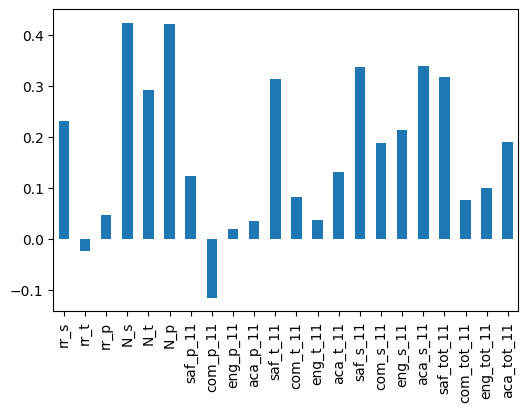

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
combined.corr()["sat_score"][survey_fields].plot.bar()

## Findings of the Correlation Analysis

The correlation is high (0.3 and above) in the following cases

### School Safety (saf_t_11 and saf_s_11)
These represent how teachers and students percieved safety.  The safety level is highly correlated with how well student do academically.

### Total Enrollment (N_s and N_p)
These represent the number of survey completed by parent and students.  Students (and their parents) who are more likely to fill out surveys amy be more likely to also be doing well academically.

### Academic standard (aca_s_11)
This indicate a strong correlation between sat score and how student perceives academic standards.  

## We will further explore the safety indicator

Text(0.5, 1.0, 'Safety indicator by Parents')

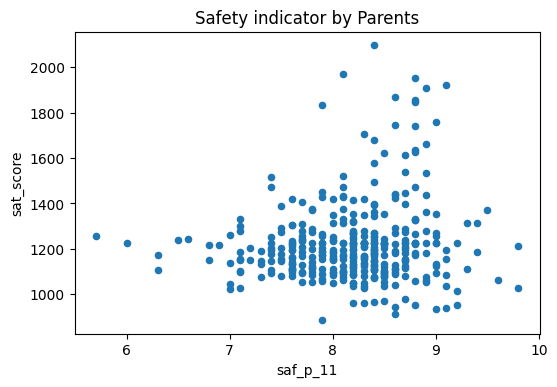

In [20]:
combined.plot.scatter('saf_p_11', 'sat_score')
plt.title(label="Safety indicator by Parents")

Text(0.5, 1.0, 'safety indicator by Students')

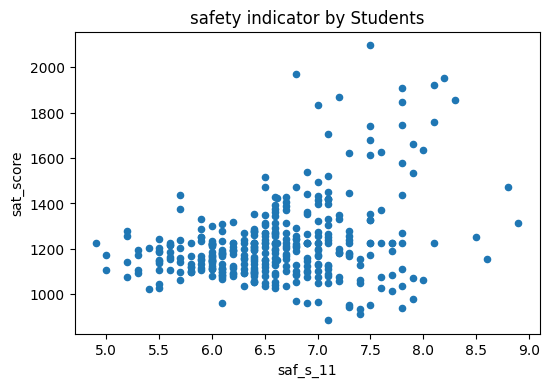

In [21]:
combined.plot.scatter("saf_s_11", "sat_score")
plt.title(label="safety indicator by Students")

Although a high safety score doesn't guarantee a high sat_score, we can see that there are no high school with a safety score lower than <mark style="background-color: #FFFF00">6.5</mark> has an average SAT score higher than <mark style="background-color: #FFFF00">1500</mark>.

In [31]:
boros = combined.groupby("boro").agg(numpy.mean)[["saf_s_11","saf_p_11","sat_score"]]
boros = boros.reset_index()
boros

,boro,saf_s_11,saf_p_11,sat_score
0,Bronx,6.606577,8.346237,1157.598203
1,Brooklyn,6.370755,8.036792,1181.364461
2,Manhattan,6.831370,8.288889,1278.331410
3,Queens,6.721875,8.098437,1286.753032
4,Staten Island,6.530000,7.800000,1382.500000


There isn't too much to conclude by grouping schools into borough.  We have Broocklyn with the lowest safety score but Bronx has the lowest sat_score.  Manhattan hs the highest safety_score while Staten island has the highest sat_score.

## Exploring the correlation between race and SAT scores

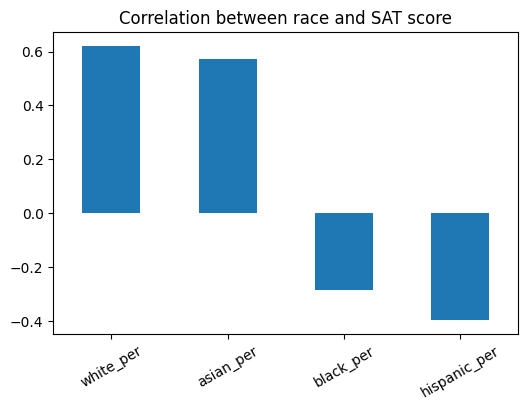

white_per       0.620718
asian_per       0.570730
black_per      -0.284139
hispanic_per   -0.396985
Name: sat_score, dtype: float64

In [48]:
race_cols = ['white_per', 'asian_per', 'black_per', 'hispanic_per']
race_corr = correlations.loc[race_cols]
race_corr.plot.bar()
plt.title(label="Correlation between race and SAT score")
plt.xticks(rotation = 30)
plt.show()
race_corr

There seem to be a strong negative correlation between black students and SAT score and a even stronger relationship between hispanic student and SAT score.

We will explore school with high hispanic student percentage.

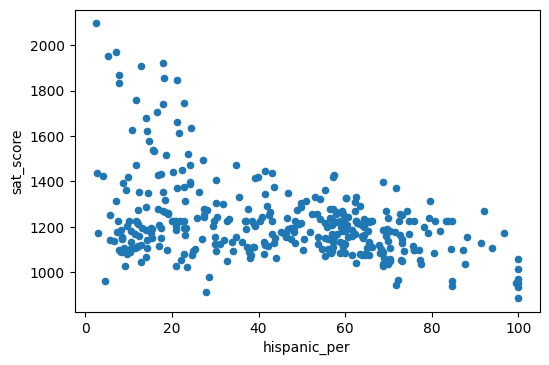

In [42]:
combined.plot.scatter("hispanic_per", "sat_score")

In [40]:
print(combined[combined["hispanic_per"]>95]["SCHOOL NAME"])

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


By doing some research on google, we found that most of the school listed above have their focus on newly immigrants who are likely to have difficulty with English.  This could be a reason why they have a low SAT score

In [41]:
print(combined[combined["hispanic_per"]<10]["SCHOOL NAME"])

37                                STUYVESANT HIGH SCHOOL
46       HIGH SCHOOL FOR DUAL LANGUAGE AND ASIAN STUDIES
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
192                          BEDFORD ACADEMY HIGH SCHOOL
194                            BENJAMIN BANNEKER ACADEMY
220                           BOYS AND GIRLS HIGH SCHOOL
223    ACADEMY FOR COLLEGE PREPARATION AND CAREER EXP...
226               THE HIGH SCHOOL FOR GLOBAL CITIZENSHIP
227                         SCHOOL FOR HUMAN RIGHTS, THE
228                  SCHOOL FOR DEMOCRACY AND LEADERSHIP
229    HIGH SCHOOL FOR YOUTH AND COMMUNITY DEVELOPMEN...
230        HIGH SCHOOL FOR SERVICE & LEARNING AT ERASMUS
231    SCIENCE, TECHNOLOGY AND RESEARCH EARLY COLLEGE...
235              MEDGAR EVERS COLLEGE PREPARATORY SCHOOL
236                             CLARA BARTON HIGH SCHOOL
237                           IT TAKES A VILLAGE ACADEMY
238                           B

The schools with low hispanic proportions and high SAT schools are Elite High Schools and also focused on Technical Education. Though this may not explain the relation between Hispanic proportion and score but their high scores could be explained by the fact that they have an entrance based admission and have students who already did well in a standardized test.

## Gender and SAT scores

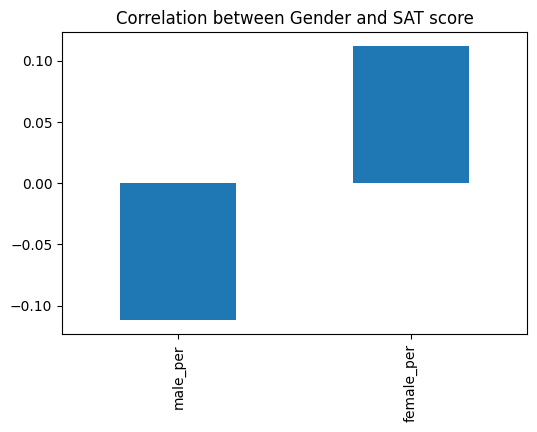

male_per     -0.112062
female_per    0.112108
Name: sat_score, dtype: float64

In [50]:
gender_field = ["male_per", "female_per"]
gender_corr = correlations.loc[gender_field]
gender_corr.plot.bar()
plt.title(label="Correlation between Gender and SAT score")
plt.show()
gender_corr


It shows there is a strong positive correlation between female student percentage and SAT score. On the other hand, a strong negative correlation between male student percentage and SAT score.  We will explore both a bit further.

Text(0.5, 1.0, 'Female student vs SAT score')

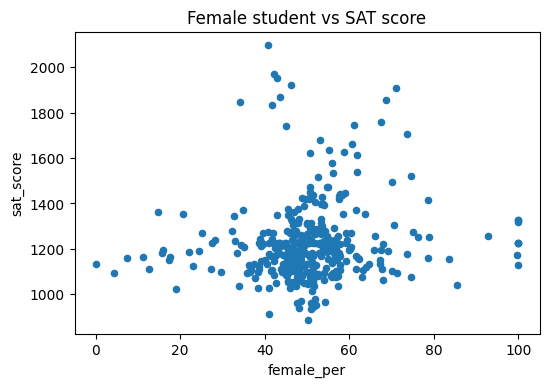

In [53]:
combined.plot.scatter("female_per", "sat_score")
plt.title(label="Female student vs SAT score")

Text(0.5, 1.0, 'Male student vs SAT_score')

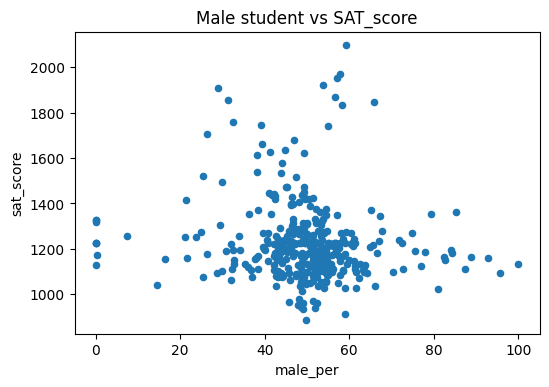

In [54]:
combined.plot.scatter("male_per", "sat_score")
plt.title(label="Male student vs SAT_score")

Looking at the two scatter plot above, we can not conclude there are any real correlations between SAT score and female_per/male_per.  However, there is a cluster of schools with female percentage between 60 to 80 that have a high SAT score

In [62]:
hfemale_bool = (combined["female_per"] > 60) & (combined["sat_score"] > 1700)

In [63]:
combined[hfemale_bool]["SCHOOL NAME"]

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

These schools appear to be very selective liberal arts schools that have high academic standards.

## AP Exam takers vs SAT score

In the U.S., high school students take Advanced Placement (AP) exams to earn college credit. There are AP exams for many different subjects.

It makes sense that the number of students at a school who took AP exams would be highly correlated with the school's SAT scores. Let's explore this relationship

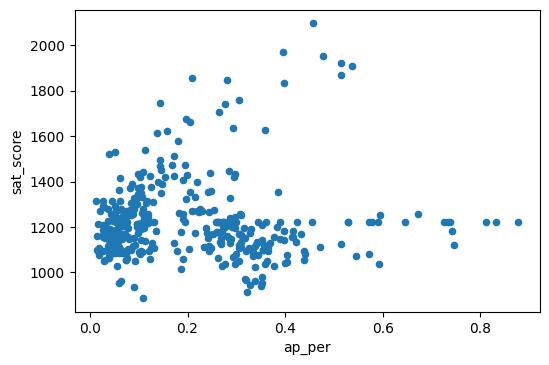

In [72]:
combined['ap_per'] = combined['AP Test Takers ']/combined['total_enrollment']
combined.plot.scatter(x='ap_per', y='sat_score')

It looks like there is a weak correlation between AP_exam taker and SAT scores